# process spectra for AuxTel with new spectractor for Ronchi

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- creation date : November 22th 2021
- last update : November 2nd 2021
- version v4 : Work with new exposure format quickLookExp_v2


This notebook is to help for finding the position of order 0

CCIN2P3:

- works with kernels **anaconda3_auxtel** (with libradtran) and **anaconda3_auxtel_v2** (no libradtran)
- works with kernel **python 3** locally 

# Ronchi

    HD2811
    # all_myseq_ronc=range(600,630)

  

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import  transforms
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re

plt.rcParams["figure.figsize"] = (12,12)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

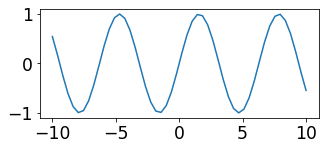

In [2]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [3]:
from iminuit import Minuit
import iminuit

In [4]:
iminuit.__version__

'2.7.0'

In [5]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor
from spectractor.extractor.images import *
from scipy import ndimage, misc

In [6]:
from scipy.stats import kurtosis,skew
from scipy.stats import kurtosistest,skewtest,normaltest

In [7]:
from distutils.dir_util import copy_tree
import shutil

# Configuration

In [8]:
version="v4.0"  # version of flipping
# create output directories if not exist and clean existing files
FLAG_MANAGE_OUTPUT_SPECTRACTOR=True
# allow to run reconstruction with Spectractor
FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR=True

FLAG_REMOVE_WCS=False

# Path

In [9]:
# path index for each month
DATE="2021-09-09"
DATE2="2021_09_09"

In [10]:
# select if we run at CC or not (locally) 
HOSTCC=False

In [11]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2021/ronchi170lpmm/quickLookExp_v2/"+DATE)
    path_output_spectractor=os.path.join(path_auxtel,"data/2021/ronchi170lpmm/OutputSpectractor/"+DATE)
    
else:
    path_auxtel="/Users/dagoret/DATA/AuxTelData2021"
    path_spectractor=os.path.join(path_auxtel,"/users/dagoret/MacOSX/github/LSST/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"ronchi170lpmm/quickLookExp_v2/"+DATE2)
    path_output_spectractor=os.path.join(path_auxtel,"ronchi170lpmm/OutputSpectractor/"+DATE)

# Utility Functions

In [12]:
def file_tag_forsorting(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^ronchi170lpmm_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [13]:
def file_tag_forsorting_holo(filename):
    #m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m=re.findall('^holo4_003_*_(.*)_.*_quickLookExp[.]fits$',filename)
    #print(m)
    words=m[0].split("_")
    
    outputstring=words[1]
    
    if outputstring=="slew":
        outputstring+="_icrs"
    return outputstring

In [14]:
def file_target(filename):
    m=file_tag_forsorting(filename)
    if len(m)>0:
        return m
    elif re.search('NGC4755',filename):
        return ['NGC4755']
    else:
        return []
         

In [15]:
def is_nan(x):
    return (x != x)

# Logbook for input file selection

- the logbook contains all input image path and possibily the order 0 position

In [16]:
filename_logbook='logbooks/auxtelronchilogbook_'+DATE2+'_' + version+'.csv'

In [17]:
!ls -l -t logbooks

total 416
-rw-r--r--  1 dagoret  staff   8854 Nov 22 13:28 auxtelronchilogbook_2021_09_09_v4.0.csv
-rw-r--r--  1 dagoret  staff   8815 Nov 22 13:28 auxtelronchilogbook_2021_09_09_v4.0.xlsx
-rw-r--r--  1 dagoret  staff  33562 Nov  4 12:13 auxtelholologbook_2021_07_07_v4.0.csv
-rw-r--r--  1 dagoret  staff  18608 Nov  4 12:13 auxtelholologbook_2021_07_07_v4.0.xlsx
-rw-r--r--  1 dagoret  staff  32505 Sep 30 15:11 auxtelholologbook_2021_07_07_v3.0.csv
-rw-r--r--  1 dagoret  staff  17705 Sep 30 15:11 auxtelholologbook_2021_07_07_v3.0.xlsx
-rw-r--r--  1 dagoret  staff  17706 Sep 29 13:51 auxtelholologbook_2021_07_07_v3.0_old.xlsx
-rw-r--r--  1 dagoret  staff  32505 Sep 28 16:33 auxtelholologbook_2021_07_07_v3.0_old.csv
-rw-r--r--  1 dagoret  staff   3460 Sep 23 11:49 auxtelholologbook_PNG_2021_09_09_v2.0.csv
-rw-r--r--  1 dagoret  staff   7087 Sep 23 11:49 auxtelholologbook_PNG_2021_09_09_v2.0.xlsx
-rw-r--r--  1 dagoret  staff   6782 Sep 23 11:44 auxtelholologbook_2021_07_06_v2.0.xlsx
-rw-r--

In [18]:
df=pd.read_csv(filename_logbook,index_col=0)

In [19]:
pd.set_option('display.max_rows', None)

In [20]:
# show the list of input files from the logbook to select the file index in the logbook
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2021-09-10T06:15:30.580,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000600_qui...,600,HD2811,empty_1,ronchi170lpmm,1.028983,1.0,...,9.0,18.0,9.1,400.0,2400.0,NaN,NaN,,1.0,1.0
1,1,2021-09-10T06:15:34.147,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000601_qui...,601,HD2811,empty_1,ronchi170lpmm,1.028996,1.0,...,9.0,18.0,9.1,400.0,2400.0,NaN,NaN,,1.0,1.0
2,2,2021-09-10T06:15:37.709,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000602_qui...,602,HD2811,empty_1,ronchi170lpmm,1.029009,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0
3,3,2021-09-10T06:15:41.301,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000603_qui...,603,HD2811,empty_1,ronchi170lpmm,1.029022,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0
4,4,2021-09-10T06:15:44.871,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000604_qui...,604,HD2811,empty_1,ronchi170lpmm,1.029036,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0
5,5,2021-09-10T06:15:48.436,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000605_qui...,605,HD2811,empty_1,ronchi170lpmm,1.029049,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0
6,6,2021-09-10T06:15:51.992,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000606_qui...,606,HD2811,empty_1,ronchi170lpmm,1.029063,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0
7,7,2021-09-10T06:15:55.562,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000607_qui...,607,HD2811,empty_1,ronchi170lpmm,1.029077,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0
8,8,2021-09-10T06:15:59.140,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000608_qui...,608,HD2811,empty_1,ronchi170lpmm,1.029090,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0
9,9,2021-09-10T06:16:02.722,/Users/dagoret/DATA/AuxTelData2021/ronchi170lp...,ronchi170lpmm_empty_HD2811_20210909_000609_qui...,609,HD2811,empty_1,ronchi170lpmm,1.029104,1.0,...,9.0,18.0,9.1,300.0,2300.0,NaN,NaN,,1.0,1.0


# Selection of input file
- the input file is selected from the logbook list above

In [21]:
# HD 2811

In [22]:
# in auxtel_ronchi170.ini :
# SPECTRACTOR_COMPUTE_ROTATION_ANGLE = disperser

In [23]:

#idx = 0 # REC1 failed  # OK2 (after putting rotation angle in spectractor/extractor/dispersers/hologram.txt)
#idx = 1 # OK
#idx = 2 # OK
#idx = 3 # OK
#idx = 4 # REC1 failed # OK2
#idx = 5 # REC1 failed # OK2
#idx = 6 # OK
#idx = 7 # OK
#idx = 8 # REC1 echec # OK2
#idx = 9 # OK
#idx = 10 # OK
#idx = 11 # OK
#idx = 12 # OK
#idx = 13 # REC1 failed # OK2
#idx = 14 # OK
#idx = 15 # OK
#idx = 16 # OK
#idx = 17 # REC1 failed # OK2
#idx = 18 # OK
#idx = 19 # REC1 failed # OK2
#idx = 20 # OK
#idx = 21 # REC1 crash # OK2
#idx = 22 # OK
#idx = 23 # OK
#idx = 24 # OK
#idx = 25 # REC1 failed # OK2
#idx = 26 # REC1 failed # OK2
#idx = 27 # REC1 VERY BAD # REC2 crash
#idx = 28 # GOOD
idx = 29



In [24]:
print(df.iloc[idx]['file'])

ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp.fits


In [25]:
print(df.iloc[idx])

index                                                         29
date                                     2021-09-10T06:17:14.230
path           /Users/dagoret/DATA/AuxTelData2021/ronchi170lp...
file           ronchi170lpmm_empty_HD2811_20210909_000629_qui...
num                                                          629
object                                                    HD2811
filter                                                   empty_1
disperser                                          ronchi170lpmm
airmass                                                 1.029386
exposure                                                     1.0
focus                                                        0.0
seeing                                                  0.626524
pressure                                                   741.0
temperature                                                  9.0
humidity                                                    18.0
windspd                  

In [26]:
myhome=os.getenv("HOME")

In [27]:
dir_images=path_images

In [28]:
dir_images

'/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/quickLookExp_v2/2021_09_09'

In [29]:
filename_image=df['file'][idx]
filename_image

'ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp.fits'

In [30]:
file_target(filename_image)

'HD2811'

## If order 0 position exists in logbook it is selected, otherwise put it by hand

In [31]:
x0=df['Obj-posXpix'][idx]
y0=df['Obj-posYpix'][idx]

In [32]:
FLAG_ORDER0_LOCATION=False

In [33]:
if not is_nan(x0)and not is_nan(y0):
    FLAG_ORDER0_LOCATION=True
    print("Order 0 location from logbook : ({},{})".format(x0,y0))
else:
    print("NO Order 0 location from logbook ! ")      

Order 0 location from logbook : (300.0,2300.0)


## Spectractor Configuration 

- Usually the Spectractor configuration file is put in local dir **./config**


Ma suggestion, pour l'étude du centre optique via les scans des hologrammes, est de **mettre SPECTRACTOR_COMPUTE_ROTATION_ANGLE sur False** . 

Comme les angles ne sont pas très grands, si les marges du rectangle sont assez larges, réglables avec : 

    [background subtraction parameters] 
    # half transverse width of the signal rectangular window in pixels 
    PIXWIDTH_SIGNAL = 40 

alors le spectrogramme devrait tenir dans une boite rectangulaire même sans rotation de l'image. **L'important est de garder SPECTRACTOR_DECONVOLUTION_FFM à True car c'est lui qui te donnera l'angle de l'axe de dispersion ajusté sur les données, dont la valeur sera dans le mot clé ROTANGLE du header de sortie**. 


In [34]:
filename_image.split(".")[0]

'ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp'

In [35]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/OutputSpectractor/2021-09-09'

In [36]:

# Fullfilename
filename=os.path.join(dir_images,filename_image)


# subdirectory
subdir=filename_image.split(".")[0]

# final output directory (where results will be copied to be backed up at the end)
finalpath_output_spectractor=os.path.join(path_output_spectractor,subdir)

# local directories to put spectra and plots
output_directory="./outputs_process_ronchi"
output_figures="figures_process_ronchi"

# Final output directory


guess = [250,2600]
disperser_label = "ronchi170lpmm"
# old version
# config = os.path.join(path_spectractor_config,"auxtel_quicklook.ini")
# new version (September 20th 2021)

# configuration

# standard spectractor init configuration
#config = os.path.join(path_spectractor_config,"auxtel.ini")
config="./config/auxtel_ronchi170.ini"

target = file_target(filename_image)[0]

In [37]:
finalpath_output_spectractor

'/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/OutputSpectractor/2021-09-09/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp'

### manage output dir

In [38]:
def cleandir(path):
    if os.path.isdir(path):
        files=os.listdir(path)
        if len(files) > 0:
            for f in files:
                if os.path.isdir(os.path.join(path,f)):
                    if f==".ipynb_checkpoints":
                        shutil.rmtree(os.path.join(path,f))
                    else:
                        print(" Cannot remove this directory {}".format(os.path.join(path,f)))
                else:
                    os.remove(os.path.join(path,f))

In [39]:
# this flag must be set if one want to clean results from previous runs
if FLAG_MANAGE_OUTPUT_SPECTRACTOR:
    
    # manage global output directory of spectractor
    # Basically it has the name of the input file image
    if not os.path.isdir(output_directory):
        os.mkdir(output_directory)
    else:
        cleandir(output_directory)
 
    # manage subdirs spectrum/ and plots/
    if not os.path.isdir(output_figures):
        os.mkdir(output_figures)
    else:
        cleandir(output_figures)
    
    if not os.path.isdir(finalpath_output_spectractor):
        os.mkdir(finalpath_output_spectractor)
        os.mkdir(os.path.join(finalpath_output_spectractor,"basespec"))
        os.mkdir(os.path.join(finalpath_output_spectractor,"plots"))
    else:
        #cleandir(finalpath_output_spectractor)
        cleandir(os.path.join(finalpath_output_spectractor,"basespec"))
        cleandir(os.path.join(finalpath_output_spectractor,"plots"))

# Configuration of the Spectractor running mode

In [40]:
parameters.debug=True
parameters.verbose=True
parameters.display=True
parameters.LIVE_FIT=False

## Load the image in the new image file with Spectractor

In [41]:
image=Image(file_name=filename, target_label=target, disperser_label=disperser_label, config=config)

2021-12-09 20:23:17  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.272641424039888 but average of self.read_out_noise is 8.5.


In [42]:
image.data.shape

(4072, 4000)

## Show relevant parameters

In [43]:
parameters.OBS_NAME

'AUXTEL'

In [44]:
parameters.DISPERSER_DIR

'/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/'

In [45]:
parameters.DISTANCE2CCD

182.0

In [46]:
parameters.LAMBDA_MIN 

300

In [47]:
parameters.LAMBDA_MAX 

1100

In [48]:
parameters.LSST_SAVEFIGPATH=True
parameters.LSST_SAVEFIGPATH=output_figures

In [49]:
image.filter_label

''

In [50]:
image.header["FILTER"]

'empty_1'

In [51]:
#image.header

# Plot image and find the target position

- this image plotting is used to find the order 0 location to be set in logbook

- for the moment this is humanly done

## Load the new image file with Spectractor

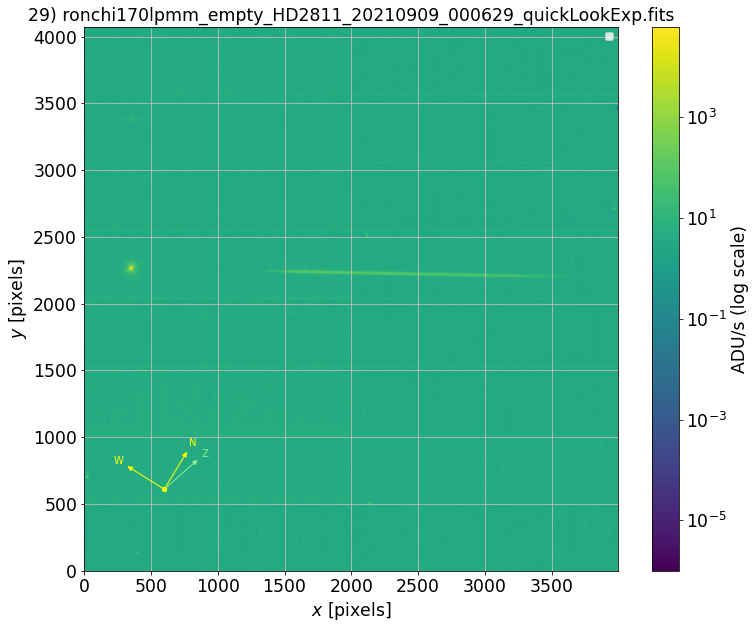

In [52]:
title="{}) {}".format(idx,filename_image)
image.plot_image(figsize=(12, 10),scale="log",title=title)

- note now the position are written in the make_logbook.ipynb notebook

## Set the 0th order location to be provided to Spectractor

In [53]:
filename_image

'ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp.fits'

In [54]:
# overwrite if localtion is taken from that in logbook
if FLAG_ORDER0_LOCATION : 
    print("Set Order 0 location from logbook : ({},{})".format(x0,y0))
    guess = [x0,y0]

Set Order 0 location from logbook : (300.0,2300.0)


## Let Spectractor find the location of the 0th order

2021-12-09 20:23:24  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                 c0_1        
    ------------------ ------------------- ---------------------
    3.1865452538330388 0.06151912837864744 -0.038935799706081006
2021-12-09 20:23:24  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 5 iterations because the relative change of cost is below ftol=1.25e-05.


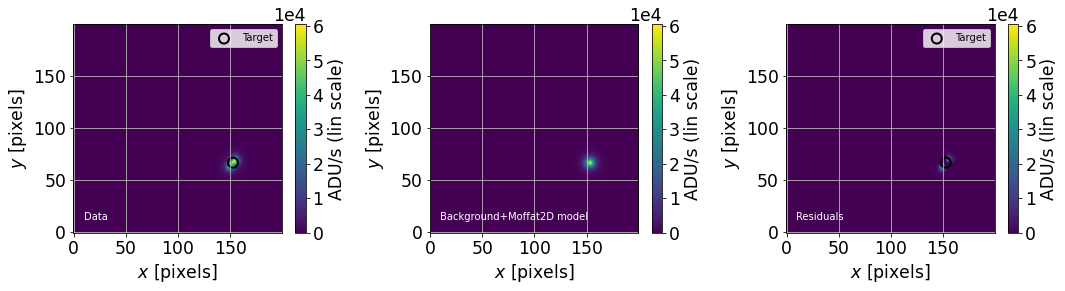

2021-12-09 20:23:25  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=5.102040816326531e-05.


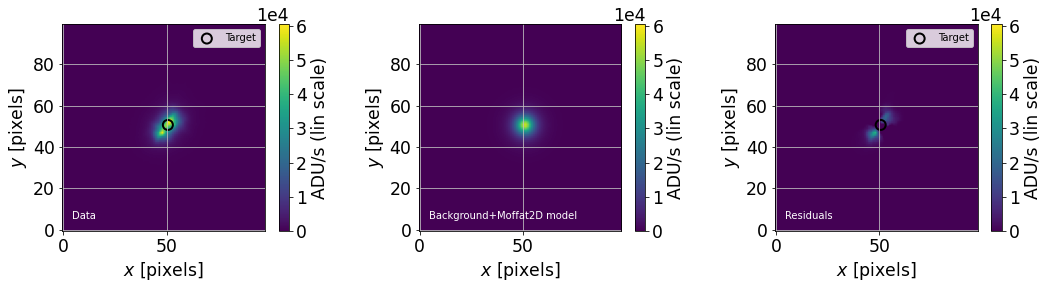

In [55]:

parameters.VERBOSE = True
parameters.DEBUG = True
#x1, y1 = find_target(image, guess,rotated=False, use_wcs=False)
x1, y1 = find_target(image, guess,rotated=False)

In [56]:
print(x1,y1)

352.6395441124439 2266.73241597286


## Check the location of 0th order and Analysis of the quality of its focus

In [57]:
if x1>100:
    WID=100
else:
    WID=50
    

thumbnail=np.copy(image.data[int(y1)-WID:int(y1)+WID,int(x1)-WID:int(x1)+WID])
thumbnail_y=thumbnail.sum(axis=1)
thumbnail_x=thumbnail.sum(axis=0)
xx=np.linspace(int(x1)-WID,int(x1)+WID,len(thumbnail_x))
yy=np.linspace(int(y1)-WID,int(y1)+WID,len(thumbnail_y))
k0=kurtosis(thumbnail,axis=None,bias=True,fisher=True)
kx=kurtosis(thumbnail_x,bias=True,fisher=True)
ky=kurtosis(thumbnail_y,bias=True,fisher=True)
s0=skew(thumbnail,axis=None,bias=True)
sx=skew(thumbnail_x,bias=True)
sy=skew(thumbnail_y,bias=True)
        

In [58]:
shape_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}, Skx = {:3.3f}, Sky = {:3.3f} \n'.format(s0,sx,sy),
        r'kurtosis : K0  = {:3.3f}, Kx  = {:3.3f},  Ky = {:3.3f}'.format(k0,kx,ky)))

In [59]:
skew_str='\n'.join((
        r'skew     : Sk0 = {:3.3f}'.format(s0),
        r'             : Skx = {:3.3f}'.format(sx),
        r'             : Sky = {:3.3f}'.format(sy)))

In [60]:
kurt_str='\n'.join((
        r'kurtosis : K0 = {:3.3f}'.format(k0),
        r'             : Kx = {:3.3f}'.format(kx),
        r'             : Ky = {:3.3f}'.format(ky)))

In [61]:
kurtosis_test_prob=kurtosistest(thumbnail,axis=None).pvalue
skew_test_prob=skewtest(thumbnail,axis=None).pvalue
normal_test_prob=normaltest(thumbnail,axis=None).pvalue

In [62]:
kurtosis_test_val=kurtosistest(thumbnail,axis=None).statistic
skew_test_val=skewtest(thumbnail,axis=None).statistic
normal_test_val=normaltest(thumbnail,axis=None).statistic

In [63]:
kurtosis_test_prob_x=kurtosistest(thumbnail_x).pvalue
skew_test_prob_x=skewtest(thumbnail_x).pvalue
normal_test_prob_x=normaltest(thumbnail_x).pvalue

In [64]:
kurtosis_test_prob_y=kurtosistest(thumbnail_y).pvalue
skew_test_prob_y=skewtest(thumbnail_y).pvalue
normal_test_prob_y=normaltest(thumbnail_y).pvalue

In [65]:
skew_str='\n'.join((
    r'skew     : Sk0 = {:3.3f}'.format(s0),
    r'             : Skx = {:3.3f}'.format(sx),
    r'             : Sky = {:3.3f}'.format(sy),
    r'             : p_test   = {:3.3e}'.format(skew_test_prob),
    r'             : p_test_x = {:3.3e}'.format(skew_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(skew_test_prob_y)))

In [66]:
kurt_str='\n'.join((
    r'kurtosis : K0 = {:3.3f}'.format(k0),
    r'             : Kx = {:3.3f}'.format(kx),
    r'             : Ky = {:3.3f}'.format(ky),
    r'             : p_test   = {:3.3e}'.format(kurtosis_test_prob),
    r'             : p_test_x = {:3.3e}'.format(kurtosis_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(kurtosis_test_prob_y)))

In [67]:
norm_str='\n'.join((
    r'normal  : p_test   = {:3.3e}'.format(normal_test_prob),
    r'             : p_test_x = {:3.3e}'.format(normal_test_prob_x),
    r'             : p_test_y = {:3.3e}'.format(normal_test_prob_y)))

In [68]:
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [69]:
#matplotlib.pyplot.hist(x, 
#                       bins=10, 
#                       range=None, 
#                       normed=False, 
#                       weights=None, 
#                       cumulative=False, 
#                       bottom=None, 
#                       histtype=u'bar', 
#                       align=u'mid', 
#                       orientation=u'vertical', 
#                       rwidth=None, 
#                       log=False, 
#                       color=None, 
#                       label=None, 
#                       stacked=False, 
#                       hold=None, 
#                       **kwargs)

<ipython-input-70-9da0d4ef5b3f>:32: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.suptitle(title,Y=1.01)


Text(0.5, 1.01, '29) ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp.fits')

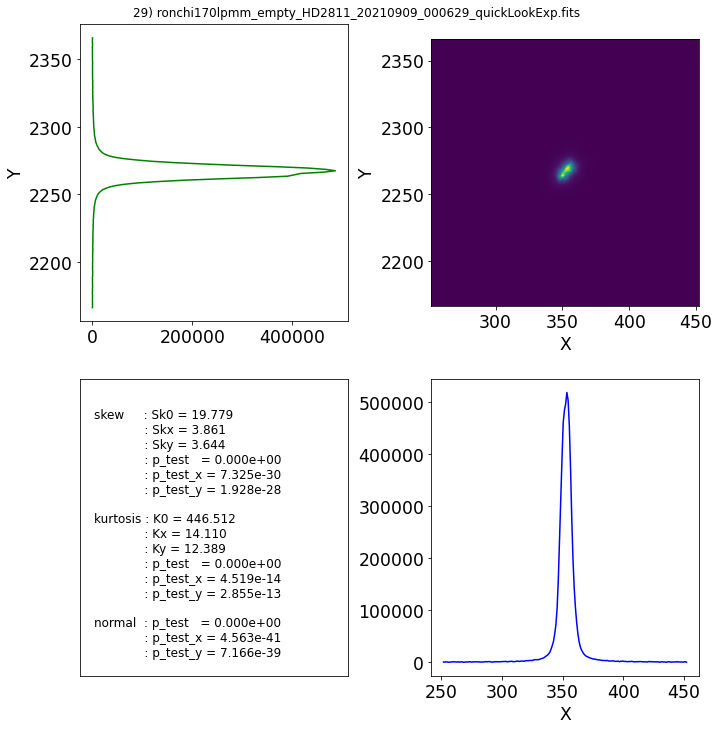

In [70]:
fig=plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0.12, right=0.95, wspace=0.3,
                    bottom=0.15, top=0.9)

ax=fig.add_subplot(222)
ax.imshow(thumbnail,origin="lower",extent=(int(x1)-WID,int(x1)+WID,int(y1)-WID,int(y1)+WID))
ax.set_xlabel("X")
ax.set_ylabel("Y")

ax=fig.add_subplot(221)
base = plt.gca().transData
rot = transforms.Affine2D().rotate_deg(-90)
#ax.plot(yy,thumbnail_y,"g",rotation=u'vertical')
ax.plot(-yy,thumbnail_y,"g",transform= rot + base)
ax.set_ylabel("Y")

ax=fig.add_subplot(224)
ax.plot(xx,thumbnail_x,"b")
ax.set_xlabel("X")
plt.tight_layout()

ax=fig.add_subplot(223)
ax.set_xlim(0,10)
ax.set_ylim(0,10)
ax.set_xticklabels([])
ax.set_xticks([])
ax.set_yticks([])

ax.text(0.05, 0.9, skew_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.55, kurt_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
ax.text(0.05, 0.2, norm_str, transform=ax.transAxes, fontsize=12,verticalalignment='top', bbox=props)
plt.suptitle(title,Y=1.01)

In [71]:
# Usually stop here if one just want to get the 0th order location
if not FLAG_GO_FOR_RECONSTRUCTION_WTH_SPECTRACTOR:
    assert False
else:
    assert True

# Go for spectrum reconstruction

In [72]:
#parameters.debug=True
#parameters.verbose=True
#parameters.display=True
#parameters.LIVE_FIT=False

In [73]:
parameters.debug=False
parameters.verbose=False
parameters.display=True
parameters.LIVE_FIT=False

In [74]:
filename

'/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/quickLookExp_v2/2021_09_09/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp.fits'

2021-12-09 20:23:27  spectractor.extractor.extractor Spectractor          INFO   
	Start SPECTRACTOR
2021-12-09 20:23:27  Image      load_AUXTEL_image    INFO   
	Loading AUXTEL image /Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/quickLookExp_v2/2021_09_09/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp.fits...
2021-12-09 20:23:27  Image      load_AUXTEL_image    INFO   
	Image loaded


Section: paths
x disperser_dir: extractor/dispersers/	=> parameters.DISPERSER_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/	 <class 'str'>
x throughput_dir: simulation/AuxTelThroughput/	=> parameters.THROUGHPUT_DIR: /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/simulation/AuxTelThroughput/	 <class 'str'>
Section: pipeline
x spectractor_fit_target_centroid: fit	=> parameters.SPECTRACTOR_FIT_TARGET_CENTROID: fit	 <class 'str'>
x spectractor_compute_rotation_angle: disperser	=> parameters.SPECTRACTOR_COMPUTE_ROTATION_ANGLE: disperser	 <class 'str'>
x spectractor_deconvolution_psf2d: False	=> parameters.SPECTRACTOR_DECONVOLUTION_PSF2D: False	 <class 'bool'>
x spectractor_deconvolution_ffm: True	=> parameters.SPECTRACTOR_DECONVOLUTION_FFM: True	 <class 'bool'>
Section: instrument
x obs_name: AUXTEL	=> parameters.OBS_NAME: AUXTEL	 <class 'str'>
x obs_altitude: 2.66299616375123

2021-12-09 20:23:27  Image      load_image           INFO   
	Loading disperser ronchi170lpmm...
2021-12-09 20:23:27  Hologram   load_specs           INFO   
	Load disperser ronchi170lpmm:
	from /users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/dispersers/ronchi170lpmm
2021-12-09 20:23:27  Hologram   load_specs           INFO   
	Grating characteristics:
	N = 170.00 +/- 0.10 grooves/mm
	Average tilt of -1.1 degrees
2021-12-09 20:23:31  Image      check_statistical_error WARNING 
	Fitted read out noise seems to be different than input readout noise. Fit=8.272641424039888 but average of self.read_out_noise is 8.5.
2021-12-09 20:23:31  Star       load                 INFO   
	Simbad:
 MAIN_ID        RA           DEC      ... Z_VALUE_2 SCRIPT_NUMBER_ID
             "h:m:s"       "d:m:s"    ...                           
--------- ------------- ------------- ... --------- ----------------
HD   2811 00 31 18.4899 -43 36 23.000 ...        -- 

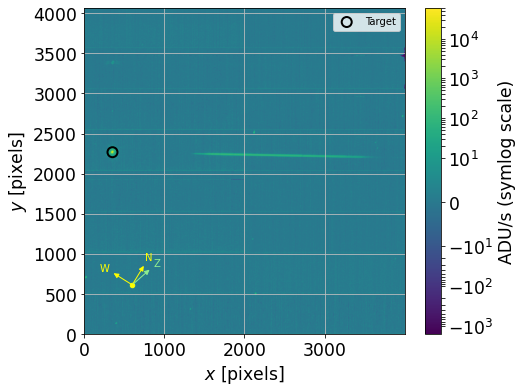

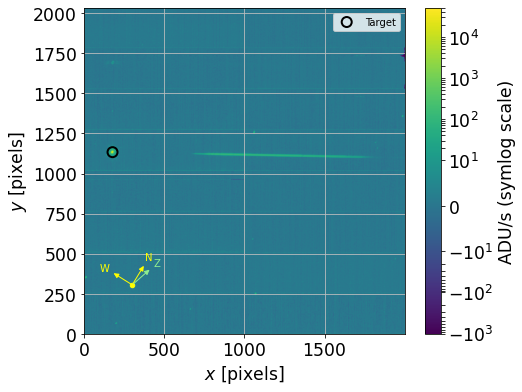

2021-12-09 20:23:38  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the image with guess=[ 176.31977206 1133.36620799]...
2021-12-09 20:23:38  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0               c1_0                  c0_1        
    ----------------- -------------------- ---------------------
    4.024747050104304 0.008137091194128032 -0.001965726111747661
2021-12-09 20:23:38  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 3 iterations because the relative change of cost is below ftol=5e-05.


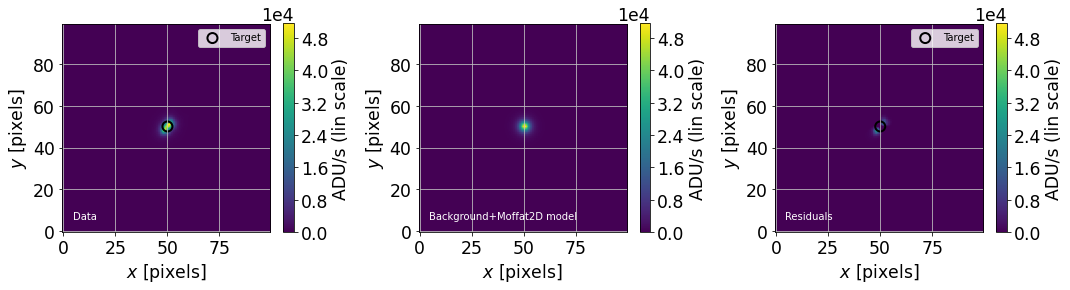

2021-12-09 20:23:39  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=0.0002.


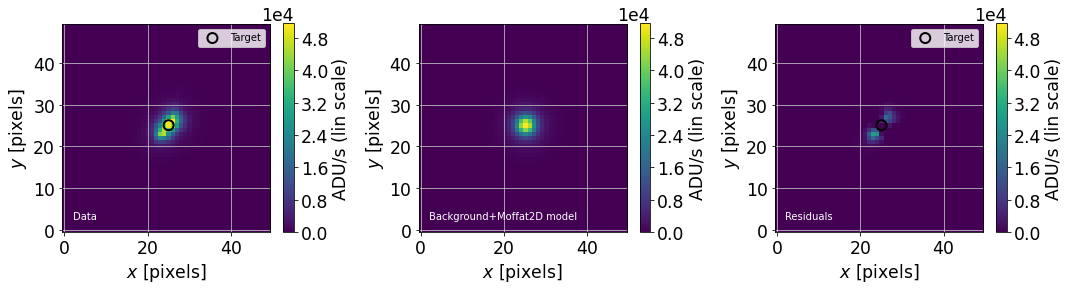

2021-12-09 20:23:40  Image      find_target          INFO   
	X,Y target position in pixels: 176.064,1133.105
2021-12-09 20:23:40  Image      turn_image           INFO   
	Rotate the image with angle theta=-1.05 degree


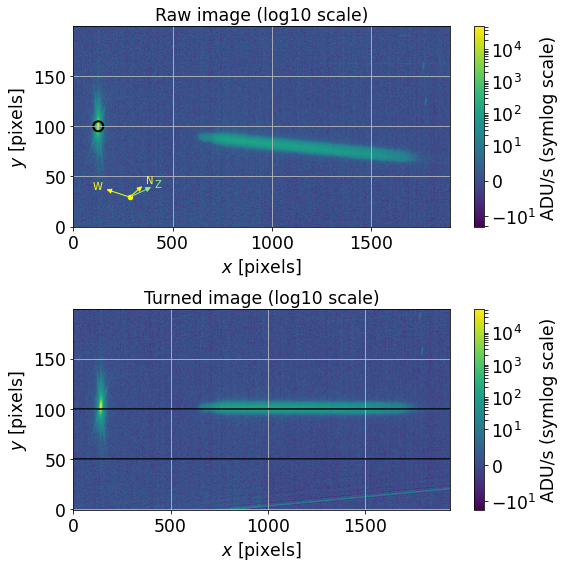

2021-12-09 20:23:44  spectractor.extractor.extractor Spectractor          INFO   
	Search for the target in the rotated image...
2021-12-09 20:23:45  spectractor.tools fit_poly2d_outlier_removal INFO   
	Model: Polynomial2D
Inputs: ('x', 'y')
Outputs: ('z',)
Model set size: 1
Degree: 1
Parameters:
           c0_0                c1_0                c0_1       
    ------------------ ------------------- -------------------
    14.064332036076097 0.12672152722955612 0.12014557920541494
2021-12-09 20:23:45  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 4 iterations because the relative change of cost is below ftol=0.0002.


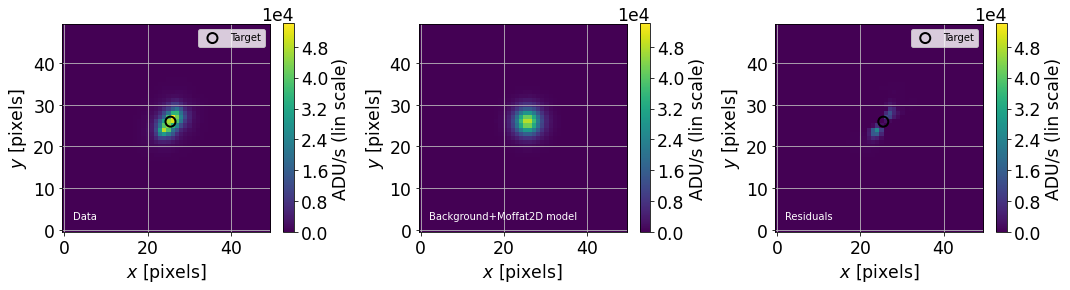

2021-12-09 20:23:45  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 2 iterations because the relative change of cost is below ftol=0.0008680555555555555.


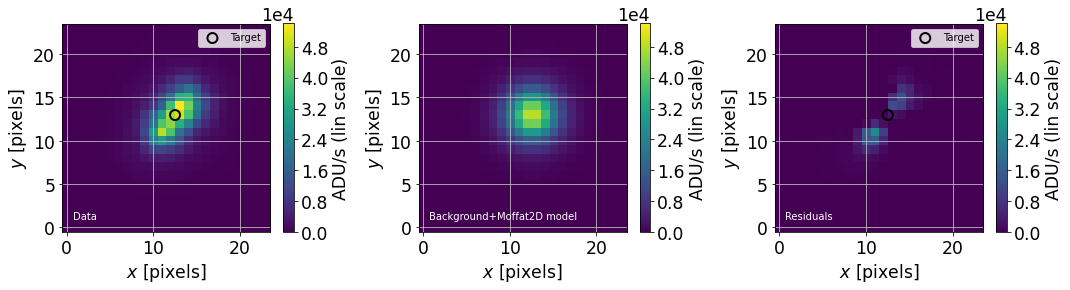

2021-12-09 20:23:46  Image      find_target          INFO   
	X,Y target position in pixels: 192.511,1135.966
2021-12-09 20:23:46  Spectrum   __init__             INFO   
	Spectrum info copied from image
2021-12-09 20:23:46  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extracting spectrum from image: spectrum with width 2*20 pixels and background from 70 to 90 pixels
2021-12-09 20:23:46  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop rotated image [657:1924,1045:1225] (size (1267, 180))


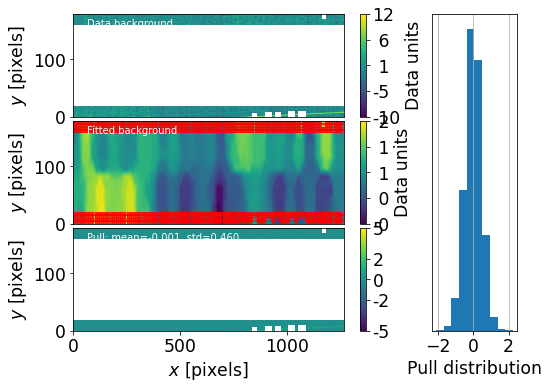

2021-12-09 20:23:49  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Start PSF1D transverse fit...
/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/psf.py:562: RuntimeWarning: invalid value encountered in true_divide
  out = evaluate_moffat1d_unnormalized(y, amplitude, y_c, gamma, alpha) / norm
/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/extractor/psf.py:562: RuntimeWarning: divide by zero encountered in true_divide
  out = evaluate_moffat1d_unnormalized(y, amplitude, y_c, gamma, alpha) / norm
/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/tools.py:1256: RuntimeWarning: invalid value encountered in subtract
  a = x[imax + np.argmin(np.abs(y[imax:] - 0.9 * maximum))]
/users/dagoret/anaconda3/lib/python3.8/site-packages/Spectractor-2.1-py3.8.egg/spectractor/tools.py:1257: RuntimeWarning: invalid value encountered in subtract
 

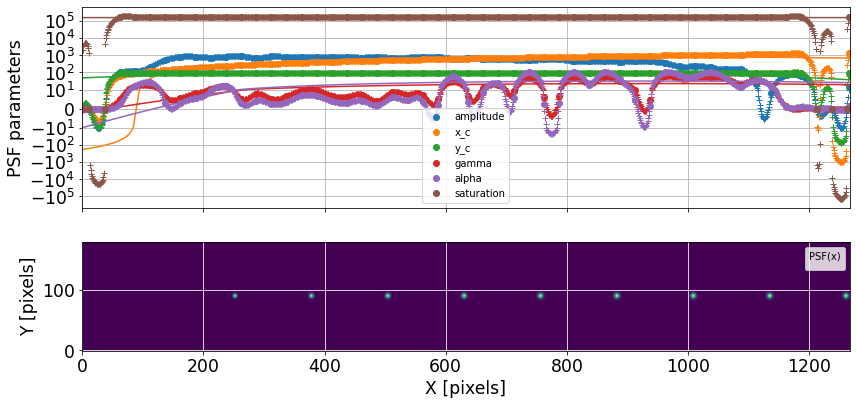

2021-12-09 20:23:54  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=13190 initial chisq_red=0.26026
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ -0.04460027  -0.09648577   0.02987751  -2.61235345  -5.10596143
  -7.2042715  -13.12899292 -23.38096312 -17.37908849]
	New parameters: [-2.15451206 -0.78581142  0.23389493 19.13868858 19.95381656 10.82861532
 17.9449718  22.71576791 12.80684408]
	Final cost=9735 final chisq_red=0.19209 computed in 0.86s
2021-12-09 20:23:55  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=9735 initial chisq_red=0.19209
		 Line search: alpha_min=1 iter=1 funcalls=5
	Parameter shifts: [ 3.76758267e-02  5.75104607e-02 -9.84652398e-03 -5.80662735e+00
 -1.01502528e+01 -6.39859123e+00 -8.44156922e+00 -1.48087866e+01
 -9.06794932e+00]
	New parameters: [-2.11683623 -0.72830095  0.22404841 13.33206123  9.80356378  4.43002409
  9.50340258  7.90698129  3.73889476]
	Final cost=9616.3 final

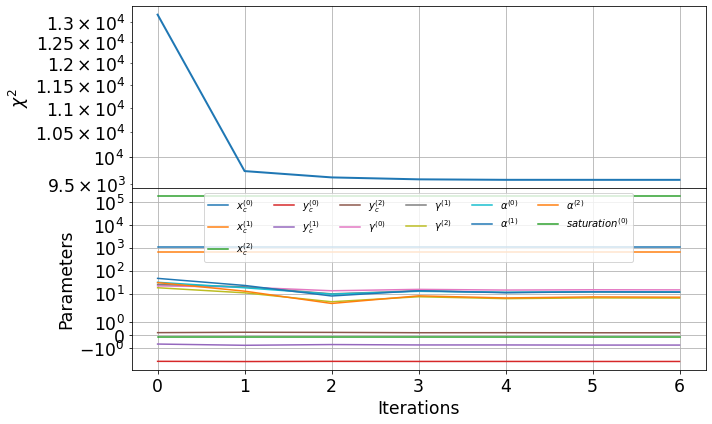

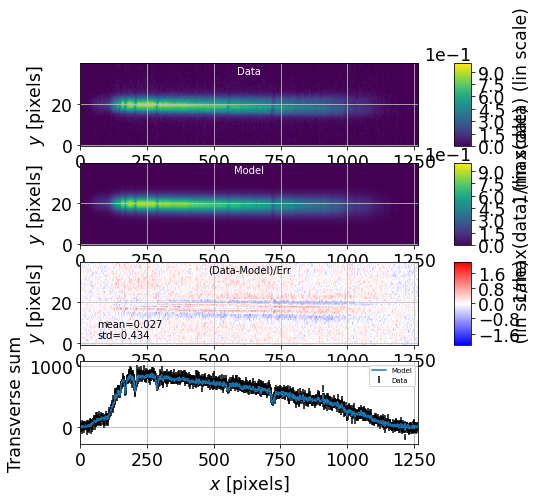

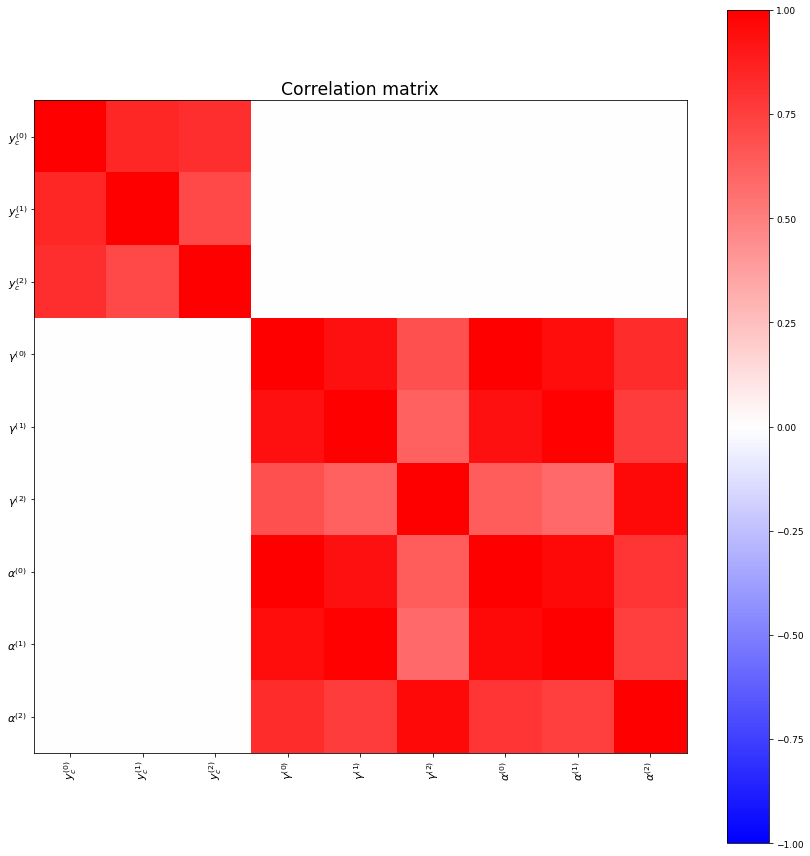

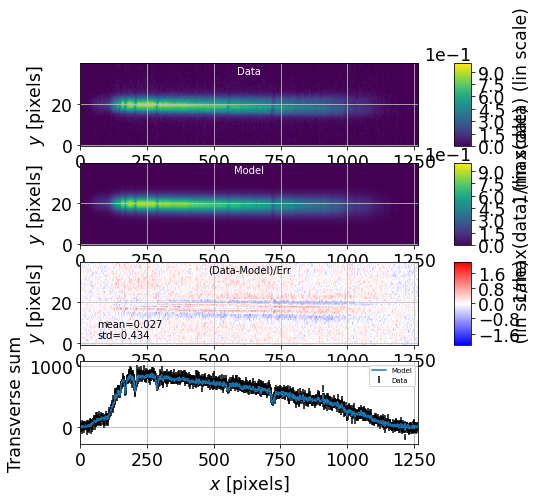

2021-12-09 20:24:06  spectractor.extractor.extractor extract_spectrum_from_image DEBUG  
	Transverse fit table before derotation:
     amplitude        x_c   ...          Dy         Dy_disp_axis
-------------------- ------ ... ------------------- ------------
   11.39027383129801    0.0 ... -1.1759268990369804          0.0
  -6.545962091523549    1.0 ...  -1.178060933047746          0.0
  -8.855523666838819    2.0 ...  -1.180193513001612          0.0
-0.35944227600943096    3.0 ... -1.1823246388985638          0.0
 -3.9634157421526406    4.0 ... -1.1844543107386158          0.0
  -17.44776098103622    5.0 ... -1.1865825285217682          0.0
 -12.419500179695508    6.0 ... -1.1887092922480065          0.0
   16.43483735178778    7.0 ...  -1.190834601917345          0.0
 -19.664975753413202    8.0 ... -1.1929584575297838          0.0
   -4.60148956720473    9.0 ... -1.1950808590853086          0.0
                 ...    ... ...                 ...          ...
  -4.876499234737461 1256

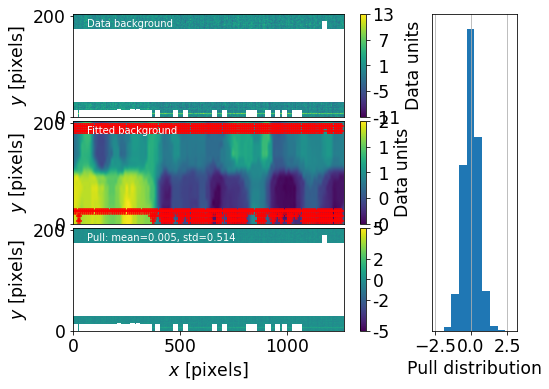

2021-12-09 20:24:09  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Background statistics: mean=0.710 ADU/s, RMS=3.741 ADU/s.
2021-12-09 20:24:09  spectractor.extractor.extractor extract_spectrum_from_image INFO   
	Extract spectrogram: crop image [640:1907,1012:1216] (size (1267, 204))
	New target position in spectrogram frame: [-463.93579771230486, 121.10539090841758]


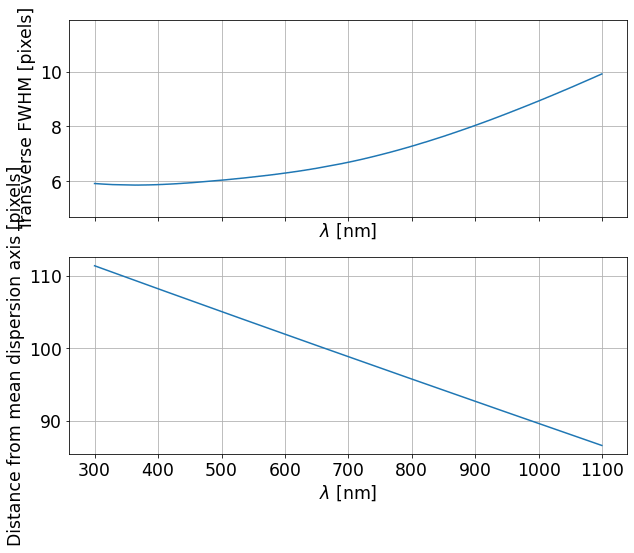

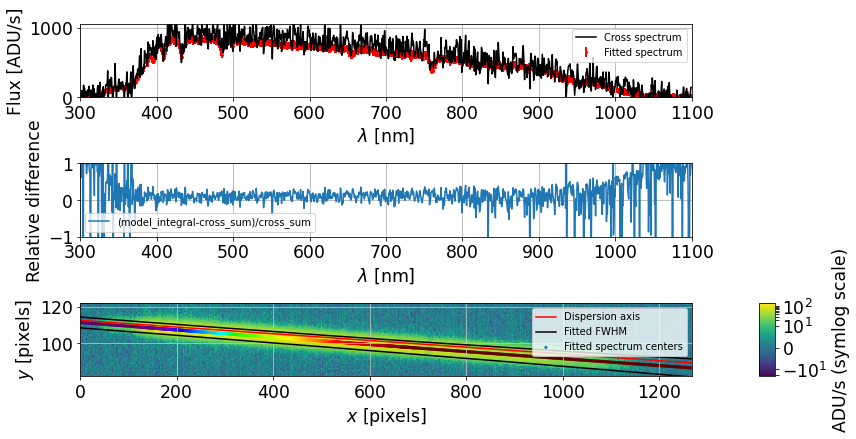

2021-12-09 20:24:11  spectractor.extractor.extractor Spectractor          INFO   
	Calibrating order 1 spectrum...


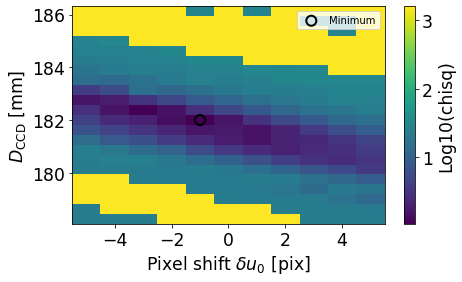

2021-12-09 20:24:29  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -1.856pix
	D = 182.155 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, 0.2 sigma shift)
2021-12-09 20:24:31  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=1.
2021-12-09 20:24:58  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=78640 initial chisq_red=1.5092
		 Line search: alpha_min=1.85 iter=0 funcalls=5
	Parameter shifts: [-2.88666883 -0.01520346]
	New parameters: [-1.904      -1.06756654]
	Final cost=12558 final chisq_red=0.24101 computed in 22.12s
2021-12-09 20:25:26  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=1: initial cost=12558 initial chisq_red=0.24101
		 Line search: alpha_min=0.382 iter=3 funcalls=7
	Parameter shifts: [-0.05809509  0.00435063]
	New parameters: [-1.904      -1.06321591]
	Final cost=12553 final chisq_red=0.24091 computed in 27.52s
2021-12-09 20:25:26  spectra

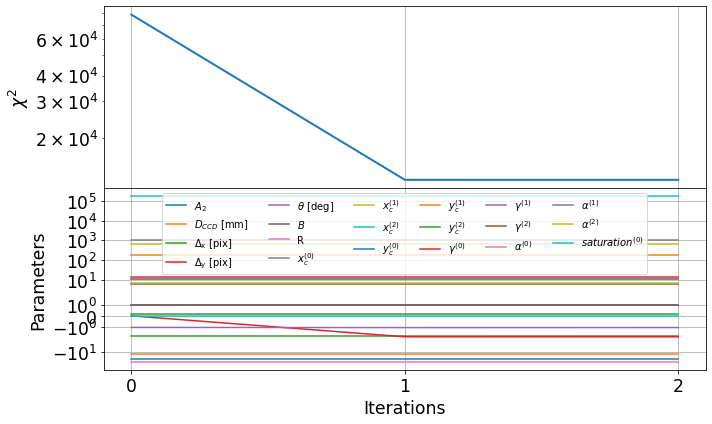

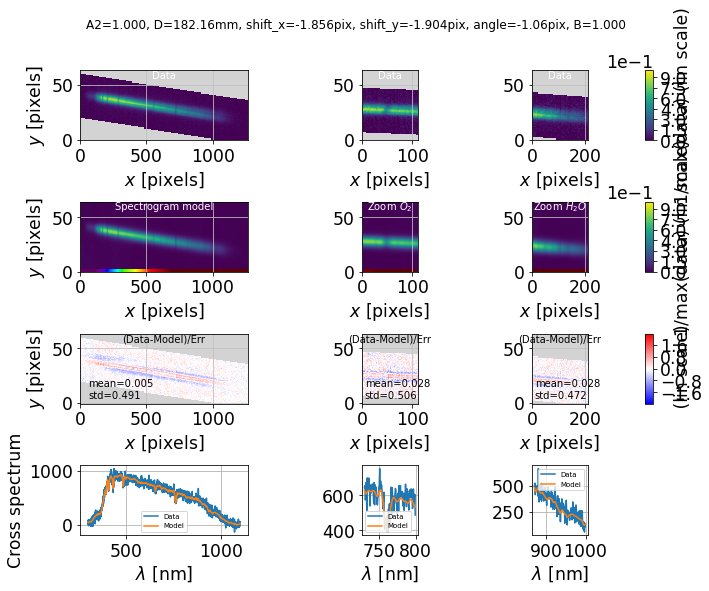

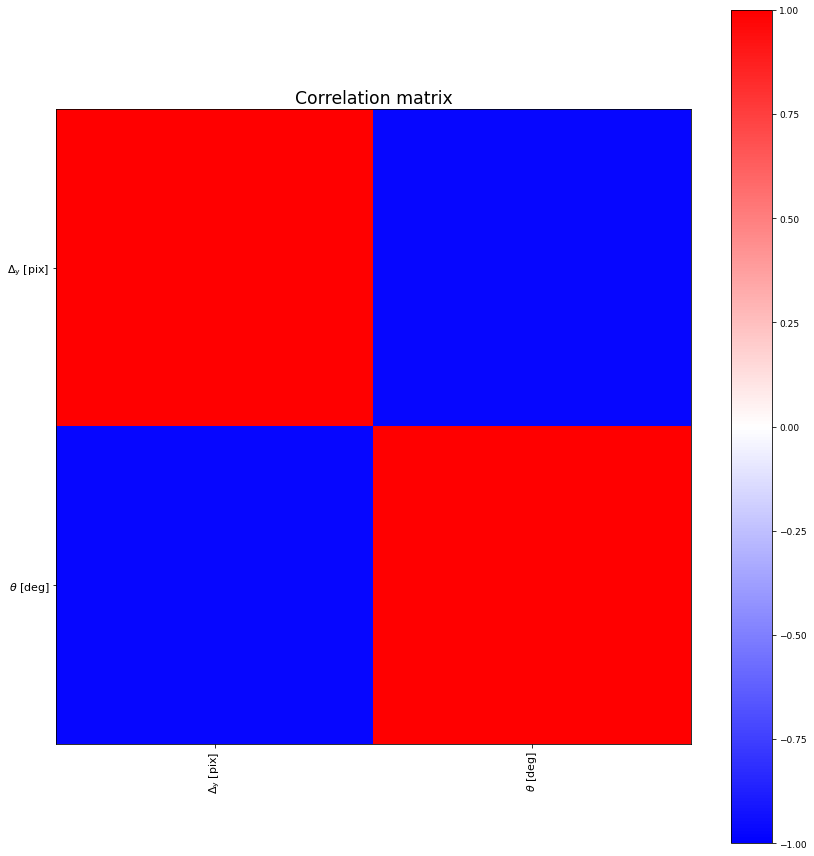

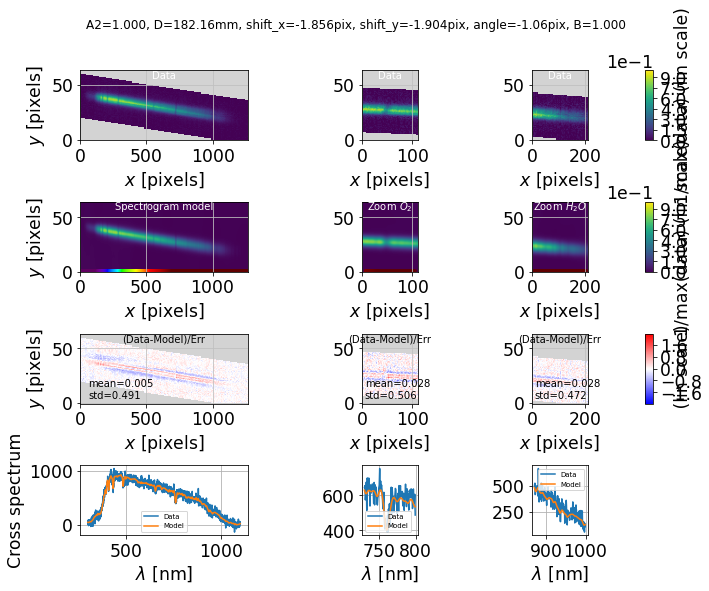

2021-12-09 20:25:38  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Start guess: [ 1.00000000e+00  1.82155494e+02 -1.85607548e+00 -1.90400000e+00
 -1.06321591e+00  1.00000000e+00 -3.15902222e+01  1.09730392e+03
  6.32893230e+02  1.08272910e-12 -2.22951216e+01 -1.23943338e+01
  1.94175445e-01  1.45667918e+01  1.16486783e+01  6.39542094e+00
  1.17871193e+01  1.15748358e+01  6.99668852e+00  1.69998948e+05]
	with ['A2', 'D_CCD [mm]', 'shift_x [pix]', 'shift_y [pix]', 'angle [deg]', 'B', 'R', 'x_c_0', 'x_c_1', 'x_c_2', 'y_c_0', 'y_c_1', 'y_c_2', 'gamma_0', 'gamma_1', 'gamma_2', 'alpha_0', 'alpha_1', 'alpha_2', 'saturation_0']
2021-12-09 20:26:35  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=12553 initial chisq_red=0.24091
		 Line search: alpha_min=0.0763 iter=6 funcalls=10
	Parameter shifts: [-0.30003271 -0.03349757  0.00210966 -0.05867733 -0.06177896 -0.04489233
 -0.06965146 -0.14533137 -0.11429791]
	New parameters: [ 0.69996729 -1.904      

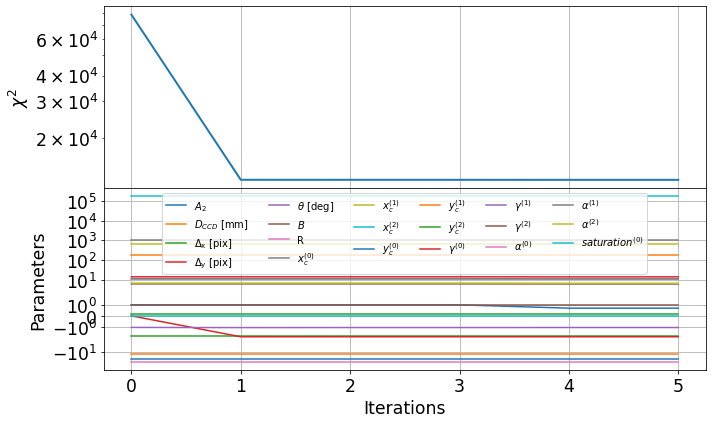

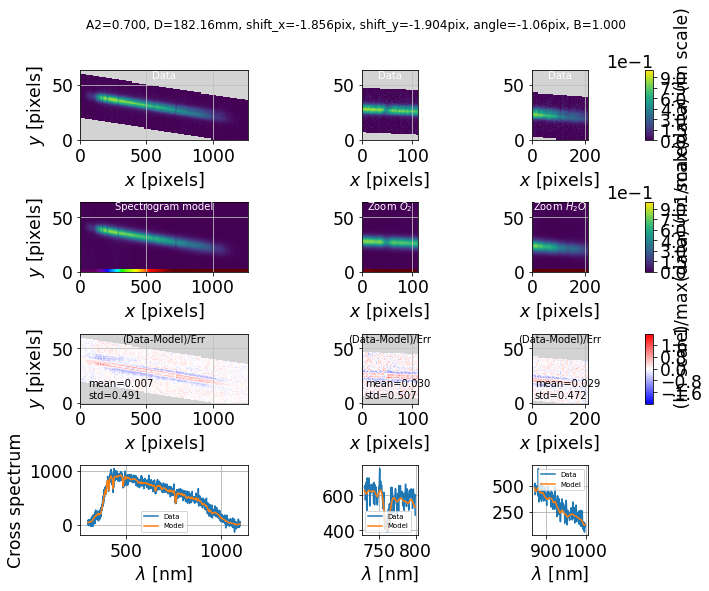

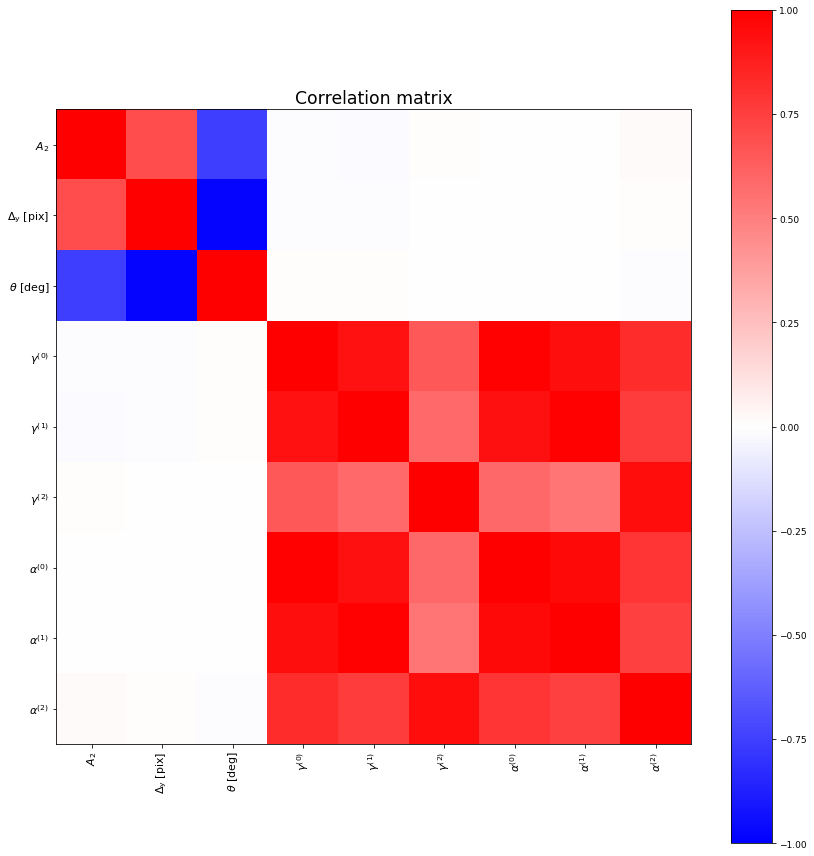

2021-12-09 20:28:51  spectractor.fit.fitter run_minimisation     DEBUG  
	Start guess: [0.]
/users/dagoret/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,
2021-12-09 20:29:11  spectractor.fit.fitter run_minimisation     DEBUG  
	 final_simplex: (array([[6.1629375],
       [6.163    ]]), array([1.08197572e-11, 1.08197572e-11]))
           fun: 1.081975716531179e-11
       message: 'Optimization terminated successfully.'
          nfev: 60
           nit: 30
        status: 0
       success: True
             x: array([6.1629375])
2021-12-09 20:29:11  spectractor.fit.fitter run_minimisation     DEBUG  
	Minimize: total computation time: 20.01658797264099s


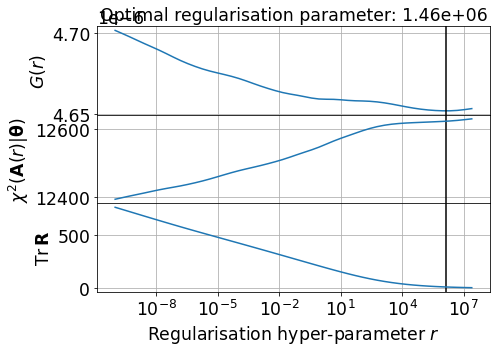

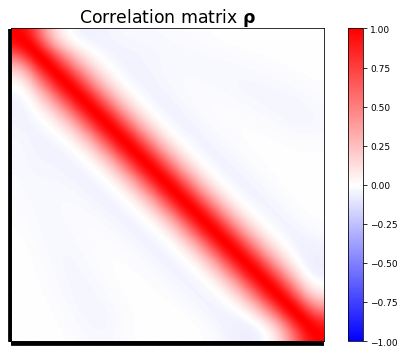

2021-12-09 20:29:50  RegFitWorkspace print_regularisation_summary INFO   
	Optimal regularisation parameter: 1455249.6382540374
	Tr(R) = 13.146783552076162
	N_params = 1267
	N_data = 52107 (without mask and outliers)
2021-12-09 20:29:52  FullForwardModelFitWorkspace run_ffm_minimisation WARNING 
	Trace of final covariance matrix (17683.740372465487) is below the trace of the prior covariance matrix (1625746.42490905). This is probably due to a very high regularisation parameter in case of a bad fit. Therefore the final covariance matrix is mulitiplied by the ratio of the traces and the amplitude parameters are very close the amplitude priors.
2021-12-09 20:30:48  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=12623 initial chisq_red=0.24227
		 Line search: alpha_min=0.128 iter=4 funcalls=8
	Parameter shifts: [-0.13928946 -0.03241752  0.00152841  0.14667695  0.22510557  0.17549916
  0.24414284  0.29924077  0.21467779]
	New parameters: [ 0.56067775 -1.904 

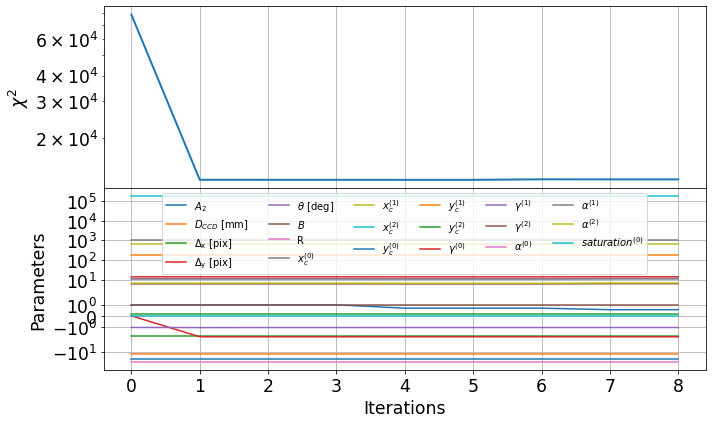

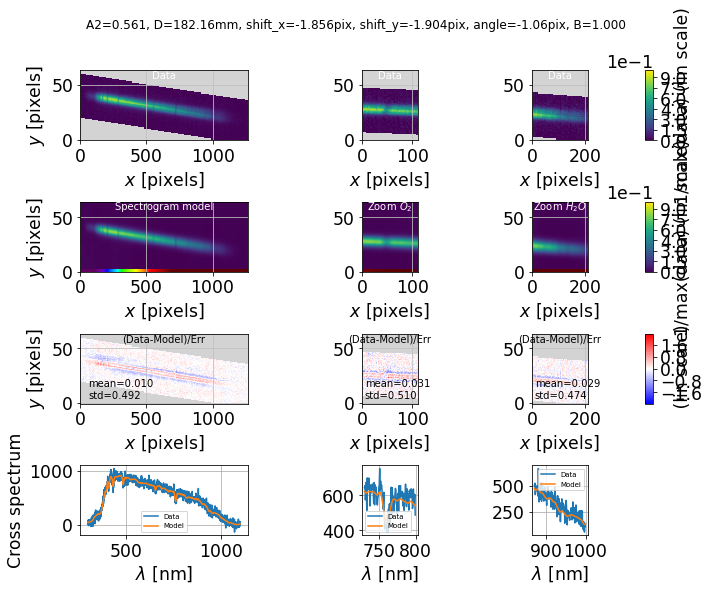

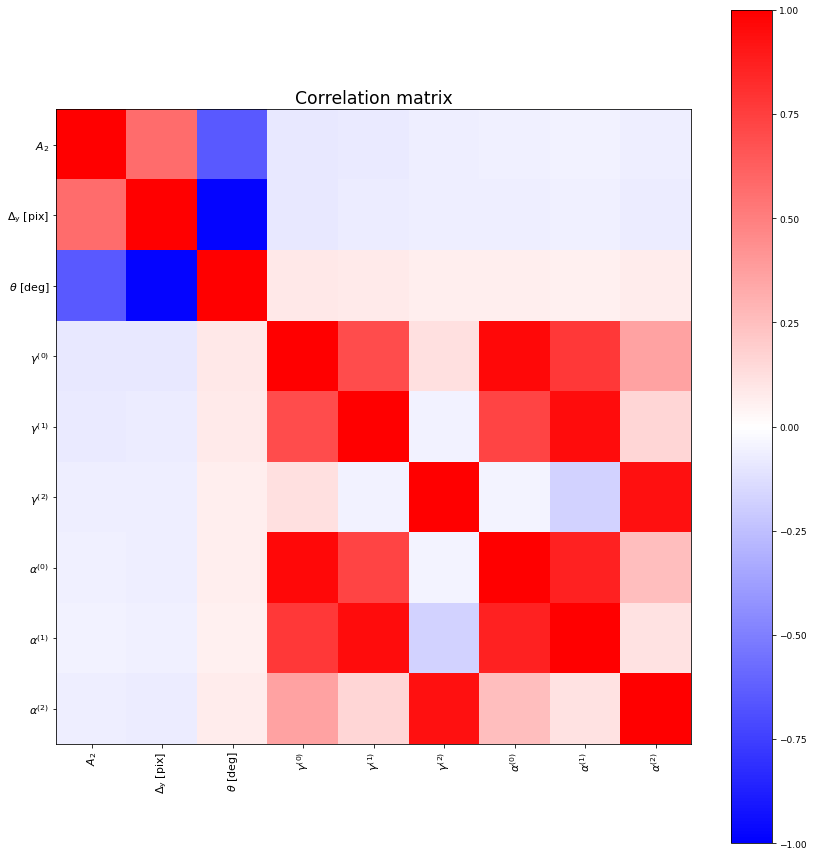

2021-12-09 20:33:25  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	No outliers detected at first iteration: break the sigma clipping iterations.
2021-12-09 20:33:25  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 466.90358805656433s


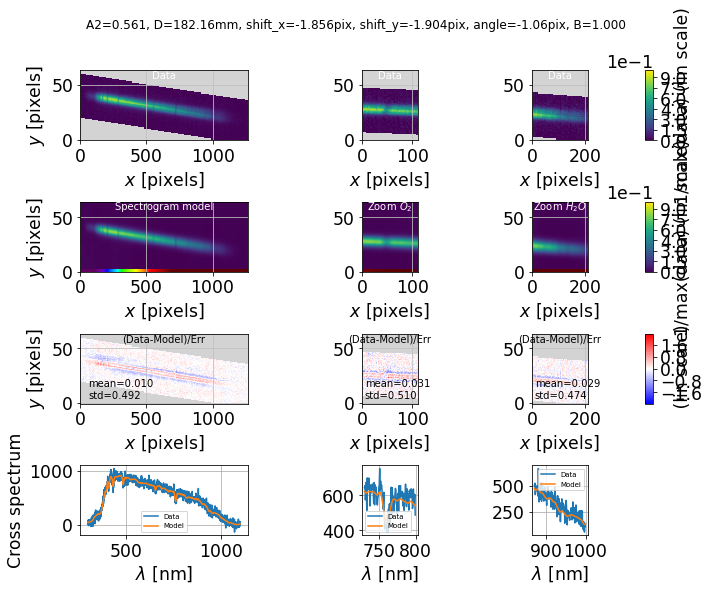

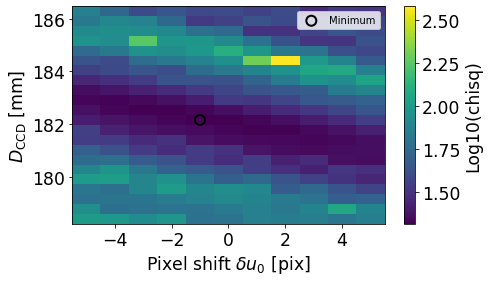

2021-12-09 20:33:48  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -1.067pix
	D = 182.266 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, 0.4 sigma shift)
2021-12-09 20:35:55  spectractor.fit.fitter gradient_descent     INFO   
	Iteration=0: initial cost=12680 initial chisq_red=0.24338
		 Line search: alpha_min=1.02e-07 iter=29 funcalls=33
	Parameter shifts: [-1.38211906e-07 -3.11904625e-08  1.31309552e-09  1.24152993e-07
  1.77785422e-07  8.71623714e-08  2.03010043e-07  2.49362687e-07
  1.22024697e-07]
	New parameters: [ 0.56067762 -1.904      -1.05957784 14.65479158 11.81200509  6.52602785
 11.9616109  11.72874546  7.09706851]
	Final cost=12680 final chisq_red=0.24338 computed in 120.80s
2021-12-09 20:35:56  spectractor.fit.fitter gradient_descent     INFO   
	Gradient descent terminated in 0 iterations because the sum of parameter shift relative to the sum of the parameters is below xtol=1e-05.
2021-12-09 20:35:56  spectractor.fit.fitter print_parameter_summary INFO  

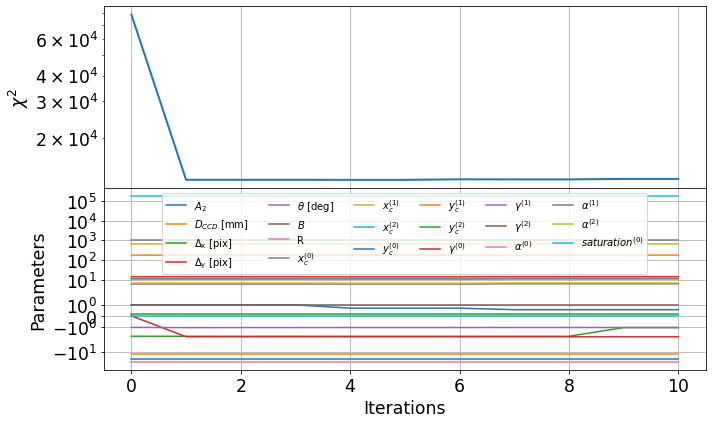

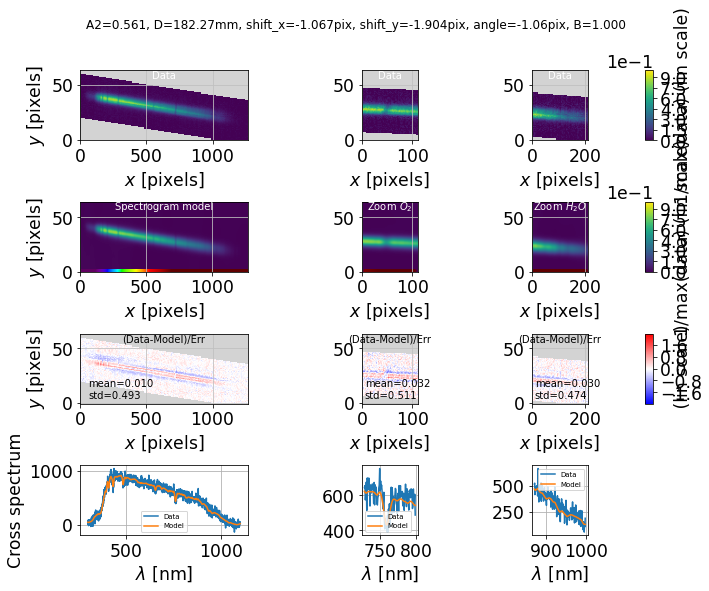

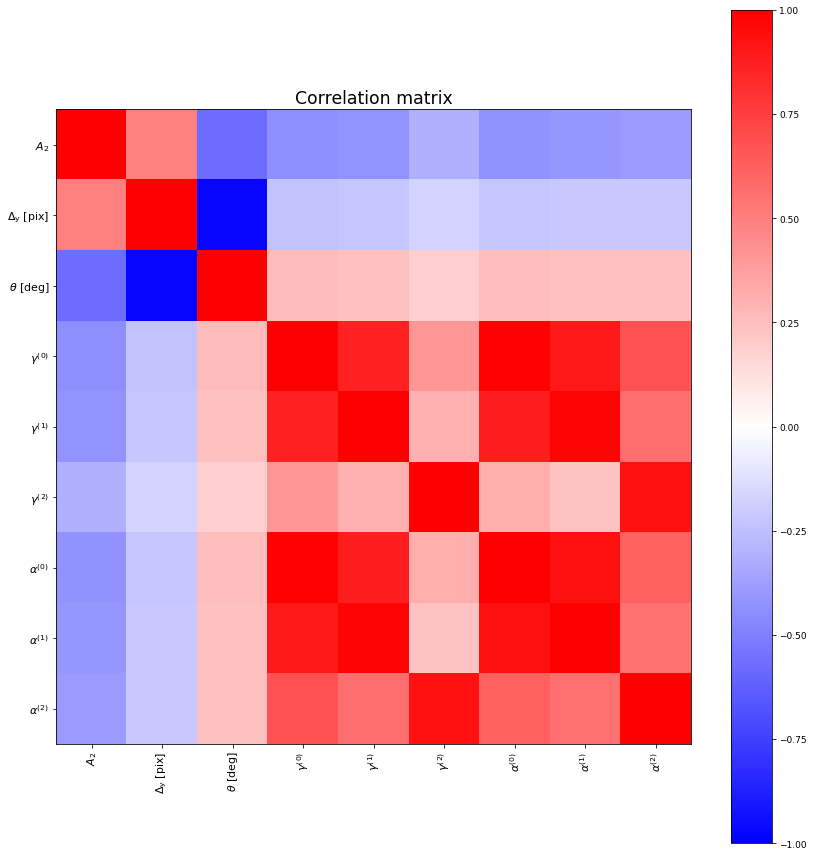

2021-12-09 20:36:04  spectractor.fit.fitter run_minimisation_sigma_clipping INFO   
	No outliers detected at first iteration: break the sigma clipping iterations.
2021-12-09 20:36:04  spectractor.extractor.extractor run_ffm_minimisation INFO   
	Newton: total computation time: 625.4669170379639s


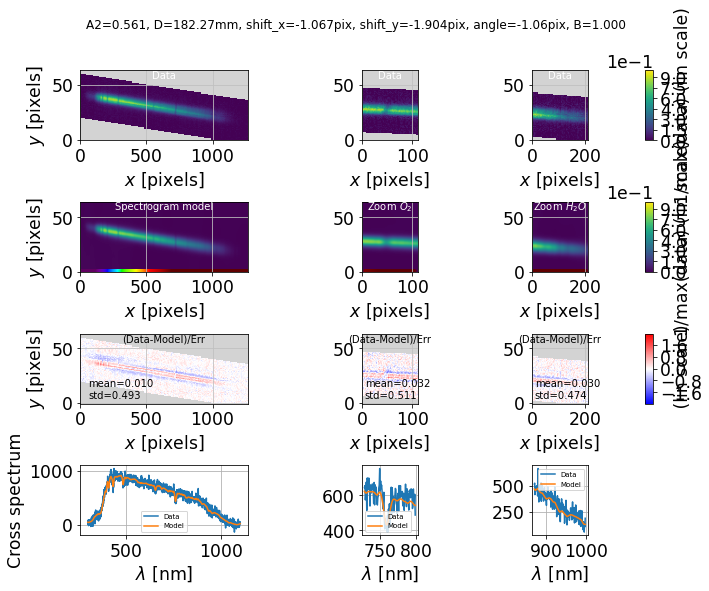

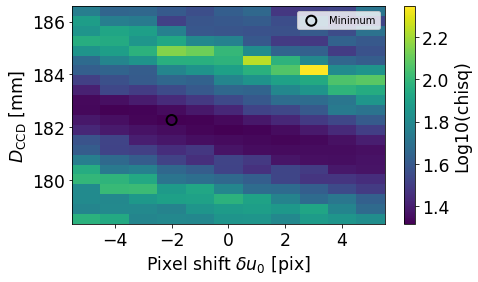

2021-12-09 20:36:29  Spectrum   calibrate_spectrum   INFO   
	Order0 total shift: -1.305pix
	D = 182.171 mm (default: DISTANCE2CCD = 182.00 +/- 0.75 mm, 0.2 sigma shift)
2021-12-09 20:36:32  Spectrum   convert_from_ADUrate_to_flam WARNING You ask to convert spectrum already in erg/s/cm$^2$/nm in erg/s/cm^2/nm... check your code ! Skip the instruction.
2021-12-09 20:36:32  astroquery _showwarning         WARNING VerifyWarning: Card is too long, comment will be truncated.
2021-12-09 20:36:33  Spectrum   save_spectrum        INFO   
	Spectrum saved in ./outputs_process_ronchi/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp_spectrum.fits
2021-12-09 20:36:33  Spectrum   save_spectrogram     INFO   
	Spectrogram saved in ./outputs_process_ronchi/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp_spectrogram.fits


    Line    Tabulated  Detected ...   Chisq   Eqwidth_mod Eqwidth_data
                nm        nm    ...  reduced       nm          nm     
----------- --------- --------- ... --------- ----------- ------------
   $Fe_{I}$   382.044 377.92792 ...  26.03543   4.3275814     -8.97166
  $Ca_{II}$   393.366 388.64795 ...  26.03543  0.45342505    1.1332209
  $Ca_{II}$   396.847   395.484 ...  26.03543   0.8761412    1.7930256
$H\epsilon$     397.0  397.2583 ...  26.03543  0.30561182    1.1252038
  $H\delta$     410.2 409.77362 ...  26.03543   1.3227311    1.3851898
   $Fe_{I}$    430.79  428.1051 ...  26.03543  0.29309323    1.8180733
  $H\gamma$     434.0 433.29788 ...  26.03543   1.2592841    1.7541412
   $Fe_{I}$   438.355 436.39084 ...  26.03543  0.22324826     1.661276
   $H\beta$     486.3 485.78967 ... 30.241373   1.4409397    1.3975282
   $Mg_{I}$    517.27  514.5163 ... 13.619392 0.028141562  0.019771932
   $Mg_{I}$    518.36  520.8401 ... 13.619392  0.06351174  0.095474415
   $Fe

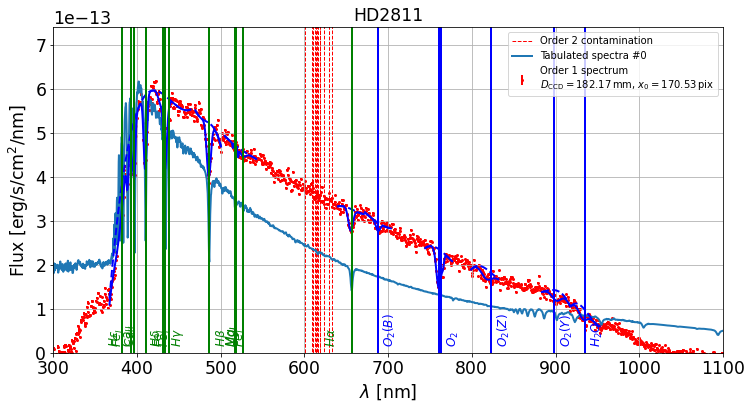

In [75]:
spectrum = Spectractor(filename, output_directory, guess=[x1,y1], target_label=target, disperser_label=disperser_label, config=config)

# Backup output

In [76]:
copy_tree(output_directory,os.path.join(finalpath_output_spectractor,"basespec"))

['/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/OutputSpectractor/2021-09-09/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp/basespec/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp_spectrum.fits',
 '/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/OutputSpectractor/2021-09-09/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp/basespec/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp_table.csv',
 '/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/OutputSpectractor/2021-09-09/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp/basespec/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp_lines.csv',
 '/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/OutputSpectractor/2021-09-09/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp/basespec/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp_spectrogram.fits']

In [77]:
copy_tree(output_figures,os.path.join(finalpath_output_spectractor,"plots"))

['/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/OutputSpectractor/2021-09-09/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp/plots/fit_chromatic_psf_best_fit_noprior.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/OutputSpectractor/2021-09-09/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp/plots/rotated_image.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/OutputSpectractor/2021-09-09/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp/plots/fwhm.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/OutputSpectractor/2021-09-09/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp/plots/order0_centroid_fit.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/OutputSpectractor/2021-09-09/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp/plots/regularisation.pdf',
 '/Users/dagoret/DATA/AuxTelData2021/ronchi170lpmm/OutputSpectractor/2021-09-09/ronchi170lpmm_empty_HD2811_20210909_000629_quickLookExp/plots/background_extraction.pdf',
 